[View in Colaboratory](https://colab.research.google.com/github/joheras/CLoDSA/blob/master/notebooks/CLODSA_Nuclei.ipynb)

# Augmenting a dataset for semantic segmentation

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to semantic segmentation. In particular, we use the dataset provided for the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018), that is divoted to find the nucle in divergent images to advance medical discovery - from now on we will call this dataset, the Nuclei dataset.

The Nuclei training dataset consists of 670 nucle images and their corresponding lbels. For illustration purposes, we take a subset of the Nucle dataset containing 100 images. Such a subset can be downloaded by executing the following command. 

In [1]:
!wget https://www.dropbox.com/s/e36y00hnwhqxu7m/nuclei.zip?dl=0 -O nuclei.zip
!unzip nuclei.zip

--2019-01-18 18:27:34--  https://www.dropbox.com/s/e36y00hnwhqxu7m/nuclei.zip?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/e36y00hnwhqxu7m/nuclei.zip [siguiente]
--2019-01-18 18:27:35--  https://www.dropbox.com/s/raw/e36y00hnwhqxu7m/nuclei.zip
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc371f95a74c0c62c80fe84fbe1b.dl.dropboxusercontent.com/cd/0/inline/AZoMQgB9uBAtxvKGe8MiMLXN5jshj1KIbVllYwjzL-NQMBrQfooybbZI_-gmDOXR7Rz7FJZXoGduXWl0k-cFx86zXLTDVZstBBzFX8bKsBwYS7yQy_zi0gtFqJZzHDqvA270qcw06d2mEkO7umLnA4TQ-a7u3VAQ8s3ma_tXKpAhp6DyG6BKBKQZIeaaSzY0C-E/file# [siguiente]
--2019-01-18 18:27:35--  https://uc371f95a74c0c62c80fe84fbe1b.dl.dropboxusercontent.com/cd/0/inline/AZoMQgB9uBAtxvKGe8MiMLXN5jshj1KIb

We can check the amount of images in each one of the folders.

In [2]:
print("Number of nuclei images")
!ls nuclei/images/ | wc -l
print("Number of masks for nuclei images")
!ls nuclei/labels/ | wc -l

Number of nuclei images
100
Number of masks for nuclei images
100


## Augmentation techniques

For this example, we consider the augmentation techniques applied in the work ["U-Net: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597), where they present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. Using such an approach, they won the [ISBI challenge for segmentation of neuronal structures in electron microscopic stacks](http://brainiac2.mit.edu/isbi_challenge/home). 

The augmentation techniques applied in that work are:
- Shifting.
- Rotation.
- Elastic deformations.

In addition, we also apply gamma correction. 

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [3]:
!pip install clodsa

    100% |████████████████████████████████| 1.5MB 7.7MB/s 
  Running setup.py bdist_wheel for clodsa ... done
  Stored in directory: /content/.cache/pip/wheels/83/22/a6/25257fd393a89d9a6e51788f399e870e68c080454a992a3c07
  Running setup.py bdist_wheel for mahotas ... done
  Stored in directory: /content/.cache/pip/wheels/ca/ed/a4/e7ca81cf5a4090f5a0a9d256fa98506902e4a25fe3e46b7907
  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /content/.cache/pip/wheels/cb/58/9b/7debccbc53159611f67cc7e2e3ed37b217e56e9b40e7ba80c3
  Running setup.py bdist_wheel for commentjson ... done
  Stored in directory: /content/.cache/pip/wheels/72/a3/90/047e693f33aa288b83e847dcdcb715fb72df1a9aa55b5cc728
Successfully built clodsa mahotas imutils commentjson


## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA.

In [3]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import cv2
%matplotlib inline

Using TensorFlow backend.


## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a semantic segmentation problem.

In [4]:
PROBLEM = "semantic_segmentation"

_The annotation mode_. The annotation is provided by the name of the folder containing the image. 

In [5]:
ANNOTATION_MODE = "folders"

_The input path_. The input path containing the images. 

In [6]:
INPUT_PATH = "nuclei/"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [7]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images_nuclei.  

In [8]:
OUTPUT_MODE = "folders"
OUTPUT_PATH= "augmented_images_nuclei/"
LABELS_EXTENSION = ".jpg"

Using the above information, we can create our augmentor object. 

In [9]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH,"labelsExtension":LABELS_EXTENSION})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



Text(0.5, 1.0, 'Blending')

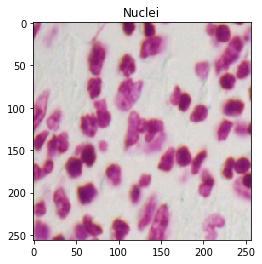

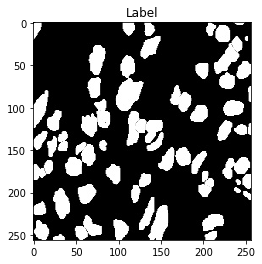

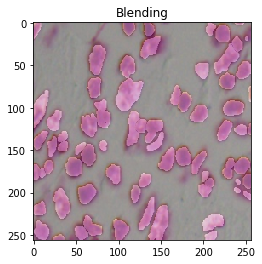

In [10]:
img = cv2.imread("nuclei/images/4.jpg")
label = cv2.imread("nuclei/labels/4.jpg")
# changing to the BGR format of OpenCV to RGB format for matplotlib
plt.figure()
plt.imshow(img[:,:,::-1])
plt.title("Nuclei")
plt.figure()
plt.imshow(label[:,:,::-1])
plt.title("Label")
dst = cv2.addWeighted(img,0.7,label,0.3,0)
plt.figure()
plt.imshow(dst[:,:,::-1])
plt.title("Blending")

First of all, we must define a transformer generator.

In [11]:
transformer = transformerGenerator(PROBLEM)

_Rotations:_

In [12]:
rotateRandom = createTechnique("rotate",{})
augmentor.addTransformer(transformer(rotateRandom))
for angle in [90,180,270]:
    rotate = createTechnique("rotate", {"angle" : angle})
    augmentor.addTransformer(transformer(rotate))

Showing the result of applying the transformation.

Text(0.5, 1.0, 'Blending')

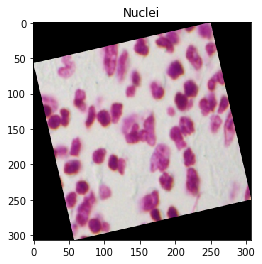

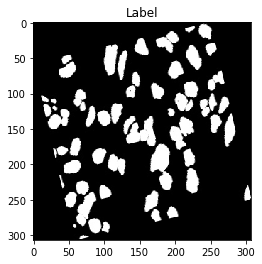

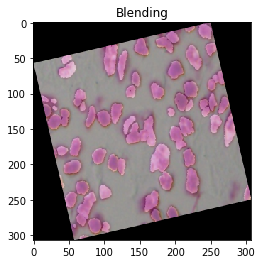

In [14]:
rotationGenerator = transformer(rotateRandom)
rotateImg,rotateLabel = rotationGenerator.transform(img,label)
plt.figure()
plt.imshow(rotateImg[:,:,::-1])
plt.title("Nuclei")
plt.figure()
plt.imshow(rotateLabel[:,:,::-1])
plt.title("Label")
dst = cv2.addWeighted(rotateImg,0.7,rotateLabel,0.3,0)
plt.figure()
plt.imshow(dst[:,:,::-1])
plt.title("Blending")

#### Shifting

In [16]:
translation = createTechnique("translation", {"x":15,"y":-5})
augmentor.addTransformer(transformer(translation))

Showing the result of applying the transformation.

Text(0.5, 1.0, 'Blending')

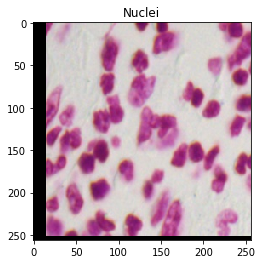

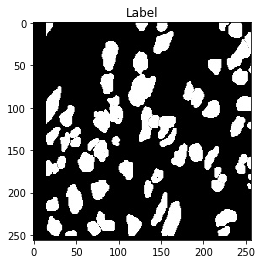

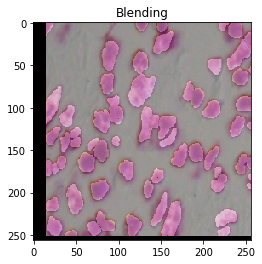

In [18]:
translationGenerator = transformer(translation)
translationImg,translationLabel = translationGenerator.transform(img,label)
plt.figure()
plt.imshow(translationImg[:,:,::-1])
plt.title("Nuclei")
plt.figure()
plt.imshow(translationLabel[:,:,::-1])
plt.title("Label")
dst = cv2.addWeighted(translationImg,0.7,translationLabel,0.3,0)
plt.figure()
plt.imshow(dst[:,:,::-1])
plt.title("Blending")

#### Elastic deformation

In [21]:
elastic = createTechnique("elastic",{"alpha":5,"sigma":0.05})
augmentor.addTransformer(transformer(elastic))

Showing the result of applying the transformation.

Text(0.5, 1.0, 'Blending')

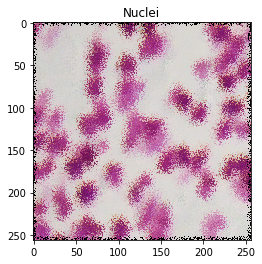

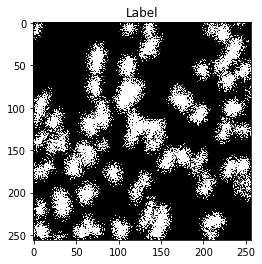

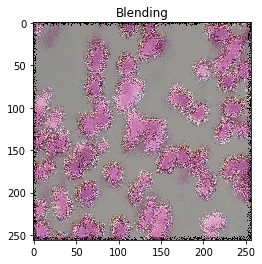

In [22]:
elasticGenerator = transformer(elastic)
elasticImg,elasticLabel = elasticGenerator.transform(img,label)
plt.figure()
plt.imshow(elasticImg[:,:,::-1])
plt.title("Nuclei")
plt.figure()
plt.imshow(elasticLabel[:,:,::-1])
plt.title("Label")
dst = cv2.addWeighted(elasticImg,0.7,elasticLabel,0.3,0)
plt.figure()
plt.imshow(dst[:,:,::-1])
plt.title("Blending")

#### Gamma correction

In [23]:
gamma = createTechnique("gamma",{"gamma":1.5})
augmentor.addTransformer(transformer(gamma))

Showing the result of applying the transformation.

Text(0.5, 1.0, 'Blending')

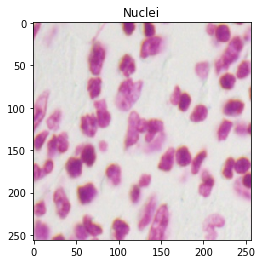

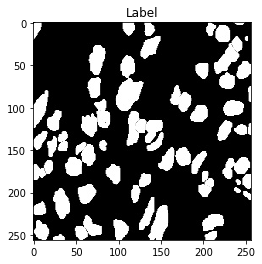

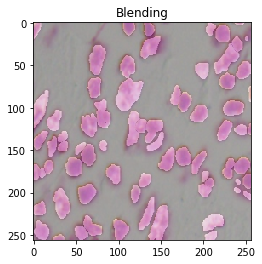

In [25]:
gammaGenerator = transformer(gamma)
gammaImg,gammaLabel = gammaGenerator.transform(img,label)
plt.figure()
plt.imshow(gammaImg[:,:,::-1])
plt.title("Nuclei")
plt.figure()
plt.imshow(gammaLabel[:,:,::-1])
plt.title("Label")
dst = cv2.addWeighted(gammaImg,0.7,gammaLabel,0.3,0)
plt.figure()
plt.imshow(dst[:,:,::-1])
plt.title("Blending")

#### None
(to keep also the original image)

In [26]:
none = createTechnique("none",{})
augmentor.addTransformer(transformer(none))

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [27]:
augmentor.applyAugmentation()

Finally, we can check the amount of images in the output folder.

In [28]:
print("Number of images in augmented nuclei folder")
!ls augmented_images_nuclei/images/ | wc -l
print("Number of images in augmented nueclei label folder")
!ls augmented_images_nuclei/labels/ | wc -l

Number of images in augmented nuclei folder
800
Number of images in augmented nueclei label folder
800


If you are executing this notebook in Colaboratory, you need to download the generated files. To that aim, you can create a zip folder and download it using the following commands. 

In [21]:
!zip -r augmented_images_nuclei.zip augmented_images_nuclei
from google.colab import files
files.download('augmented_images_nuclei.zip')

updating: augmented_images_nuclei/ (stored 0%)
updating: augmented_images_nuclei/images/ (stored 0%)
updating: augmented_images_nuclei/images/72_6_2.jpg (deflated 2%)
updating: augmented_images_nuclei/images/16_1_8.jpg (deflated 5%)
updating: augmented_images_nuclei/images/25_3_10.jpg (deflated 3%)
updating: augmented_images_nuclei/images/2_0_78.jpg (deflated 11%)
updating: augmented_images_nuclei/images/42_7_59.jpg (deflated 2%)
updating: augmented_images_nuclei/images/77_5_11.jpg (deflated 1%)
updating: augmented_images_nuclei/images/57_7_6.jpg (deflated 3%)
updating: augmented_images_nuclei/images/35_1_3.jpg (deflated 3%)
updating: augmented_images_nuclei/images/73_3_14.jpg (deflated 1%)
updating: augmented_images_nuclei/images/79_6_52.jpg (deflated 1%)
updating: augmented_images_nuclei/images/29_0_5.jpg (deflated 13%)
updating: augmented_images_nuclei/images/96_5_13.jpg (deflated 0%)
updating: augmented_images_nuclei/images/47_0_31.jpg (deflated 13%)
updating: augmented_images_nucl

updating: augmented_images_nuclei/images/21_6_48.jpg (deflated 2%)
updating: augmented_images_nuclei/images/70_3_51.jpg (deflated 4%)
updating: augmented_images_nuclei/images/26_7_73.jpg (deflated 6%)
updating: augmented_images_nuclei/images/62_3_33.jpg (deflated 1%)
updating: augmented_images_nuclei/images/44_2_87.jpg (deflated 1%)
updating: augmented_images_nuclei/images/63_6_20.jpg (deflated 3%)
updating: augmented_images_nuclei/images/20_4_22.jpg (deflated 2%)
updating: augmented_images_nuclei/images/36_4_63.jpg (deflated 2%)
updating: augmented_images_nuclei/images/28_6_29.jpg (deflated 2%)
updating: augmented_images_nuclei/images/66_7_25.jpg (deflated 1%)
updating: augmented_images_nuclei/images/17_5_89.jpg (deflated 0%)
updating: augmented_images_nuclei/images/71_3_65.jpg (deflated 7%)
updating: augmented_images_nuclei/images/43_2_85.jpg (deflated 2%)
updating: augmented_images_nuclei/images/50_2_47.jpg (deflated 3%)
updating: augmented_images_nuclei/images/21_7_48.jpg (deflated

updating: augmented_images_nuclei/images/97_2_81.jpg (deflated 1%)
updating: augmented_images_nuclei/images/22_0_23.jpg (deflated 7%)
updating: augmented_images_nuclei/images/14_1_21.jpg (deflated 2%)
updating: augmented_images_nuclei/images/3_7_0.jpg (deflated 4%)
updating: augmented_images_nuclei/images/10_6_32.jpg (deflated 4%)
updating: augmented_images_nuclei/images/70_5_51.jpg (deflated 3%)
updating: augmented_images_nuclei/images/56_7_77.jpg (deflated 3%)
updating: augmented_images_nuclei/images/84_1_88.jpg (deflated 5%)
updating: augmented_images_nuclei/images/35_6_3.jpg (deflated 2%)
updating: augmented_images_nuclei/images/31_3_44.jpg (deflated 1%)
updating: augmented_images_nuclei/images/13_6_35.jpg (deflated 1%)
updating: augmented_images_nuclei/images/65_5_45.jpg (deflated 1%)
updating: augmented_images_nuclei/images/41_5_39.jpg (deflated 0%)
updating: augmented_images_nuclei/images/14_5_21.jpg (deflated 1%)
updating: augmented_images_nuclei/images/44_1_87.jpg (deflated 1%

updating: augmented_images_nuclei/images/36_2_63.jpg (deflated 3%)
updating: augmented_images_nuclei/images/47_3_31.jpg (deflated 4%)
updating: augmented_images_nuclei/images/43_0_85.jpg (deflated 10%)
updating: augmented_images_nuclei/images/32_5_66.jpg (deflated 2%)
updating: augmented_images_nuclei/images/44_4_87.jpg (deflated 1%)
updating: augmented_images_nuclei/images/11_6_53.jpg (deflated 2%)
updating: augmented_images_nuclei/images/70_2_51.jpg (deflated 5%)
updating: augmented_images_nuclei/images/62_6_33.jpg (deflated 1%)
updating: augmented_images_nuclei/images/9_5_70.jpg (deflated 3%)
updating: augmented_images_nuclei/images/60_2_68.jpg (deflated 2%)
updating: augmented_images_nuclei/images/57_5_6.jpg (deflated 2%)
updating: augmented_images_nuclei/images/20_6_22.jpg (deflated 1%)
updating: augmented_images_nuclei/images/75_3_62.jpg (deflated 2%)
updating: augmented_images_nuclei/images/89_0_86.jpg (deflated 13%)
updating: augmented_images_nuclei/images/92_5_92.jpg (deflated

updating: augmented_images_nuclei/images/10_1_32.jpg (deflated 2%)
updating: augmented_images_nuclei/images/50_5_47.jpg (deflated 2%)
updating: augmented_images_nuclei/images/54_5_69.jpg (deflated 2%)
updating: augmented_images_nuclei/images/82_0_95.jpg (deflated 6%)
updating: augmented_images_nuclei/images/40_4_55.jpg (deflated 3%)
updating: augmented_images_nuclei/images/24_5_7.jpg (deflated 1%)
updating: augmented_images_nuclei/images/41_4_39.jpg (deflated 1%)
updating: augmented_images_nuclei/images/86_5_58.jpg (deflated 1%)
updating: augmented_images_nuclei/images/82_6_95.jpg (deflated 1%)
updating: augmented_images_nuclei/images/83_1_17.jpg (deflated 2%)
updating: augmented_images_nuclei/images/85_3_18.jpg (deflated 3%)
updating: augmented_images_nuclei/images/61_3_67.jpg (deflated 2%)
updating: augmented_images_nuclei/images/81_4_41.jpg (deflated 3%)
updating: augmented_images_nuclei/images/27_6_16.jpg (deflated 2%)
updating: augmented_images_nuclei/images/22_5_23.jpg (deflated 

updating: augmented_images_nuclei/labels/22_4_23.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/60_7_68.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/46_7_64.jpg (deflated 12%)
updating: augmented_images_nuclei/labels/15_5_74.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/16_6_8.jpg (deflated 37%)
updating: augmented_images_nuclei/labels/87_0_15.jpg (deflated 14%)
updating: augmented_images_nuclei/labels/89_2_86.jpg (deflated 21%)
updating: augmented_images_nuclei/labels/23_7_98.jpg (deflated 9%)
updating: augmented_images_nuclei/labels/72_0_2.jpg (deflated 6%)
updating: augmented_images_nuclei/labels/93_6_37.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/20_3_22.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/63_1_20.jpg (deflated 16%)
updating: augmented_images_nuclei/labels/1_0_19.jpg (deflated 15%)
updating: augmented_images_nuclei/labels/53_0_24.jpg (deflated 9%)
updating: augmented_images_nuclei/labels/21_5_48.jpg (defla

updating: augmented_images_nuclei/labels/25_6_10.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/39_0_38.jpg (deflated 6%)
updating: augmented_images_nuclei/labels/71_4_65.jpg (deflated 11%)
updating: augmented_images_nuclei/labels/16_7_8.jpg (deflated 37%)
updating: augmented_images_nuclei/labels/74_0_28.jpg (deflated 8%)
updating: augmented_images_nuclei/labels/41_6_39.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/13_7_35.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/85_1_18.jpg (deflated 12%)
updating: augmented_images_nuclei/labels/14_0_21.jpg (deflated 10%)
updating: augmented_images_nuclei/labels/19_6_99.jpg (deflated 20%)
updating: augmented_images_nuclei/labels/67_1_40.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/92_6_92.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/69_0_72.jpg (deflated 23%)
updating: augmented_images_nuclei/labels/40_3_55.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/12_1_90.jpg (def

updating: augmented_images_nuclei/labels/97_1_81.jpg (deflated 5%)
updating: augmented_images_nuclei/labels/57_1_6.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/73_1_14.jpg (deflated 5%)
updating: augmented_images_nuclei/labels/81_3_41.jpg (deflated 7%)
updating: augmented_images_nuclei/labels/24_1_7.jpg (deflated 12%)
updating: augmented_images_nuclei/labels/25_1_10.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/79_3_52.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/90_5_54.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/81_2_41.jpg (deflated 6%)
updating: augmented_images_nuclei/labels/26_6_73.jpg (deflated 22%)
updating: augmented_images_nuclei/labels/6_3_94.jpg (deflated 22%)
updating: augmented_images_nuclei/labels/69_5_72.jpg (deflated 9%)
updating: augmented_images_nuclei/labels/66_1_25.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/57_4_6.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/9_4_70.jpg (deflated 3

updating: augmented_images_nuclei/labels/19_3_99.jpg (deflated 19%)
updating: augmented_images_nuclei/labels/33_4_30.jpg (deflated 5%)
updating: augmented_images_nuclei/labels/81_6_41.jpg (deflated 7%)
updating: augmented_images_nuclei/labels/0_2_26.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/72_3_2.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/69_7_72.jpg (deflated 16%)
updating: augmented_images_nuclei/labels/48_0_36.jpg (deflated 9%)
updating: augmented_images_nuclei/labels/79_5_52.jpg (deflated 1%)
updating: augmented_images_nuclei/labels/64_0_27.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/27_4_16.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/0_3_26.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/41_3_39.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/84_7_88.jpg (deflated 9%)
updating: augmented_images_nuclei/labels/90_3_54.jpg (deflated 4%)
updating: augmented_images_nuclei/labels/4_0_61.jpg (deflated 2

updating: augmented_images_nuclei/labels/21_2_48.jpg (deflated 7%)
updating: augmented_images_nuclei/labels/96_0_13.jpg (deflated 5%)
updating: augmented_images_nuclei/labels/89_5_86.jpg (deflated 12%)
updating: augmented_images_nuclei/labels/82_3_95.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/69_2_72.jpg (deflated 15%)
updating: augmented_images_nuclei/labels/56_6_77.jpg (deflated 12%)
updating: augmented_images_nuclei/labels/58_7_82.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/31_4_44.jpg (deflated 13%)
updating: augmented_images_nuclei/labels/78_1_43.jpg (deflated 3%)
updating: augmented_images_nuclei/labels/62_7_33.jpg (deflated 8%)
updating: augmented_images_nuclei/labels/44_0_87.jpg (deflated 8%)
updating: augmented_images_nuclei/labels/22_2_23.jpg (deflated 2%)
updating: augmented_images_nuclei/labels/41_0_39.jpg (deflated 6%)
updating: augmented_images_nuclei/labels/62_4_33.jpg (deflated 5%)
updating: augmented_images_nuclei/labels/15_2_74.jpg (defl

ModuleNotFoundError: No module named 'google.colab'